# iLykei Lecture Series
# Machine Learning
# Main Deep Learning Models: Autoencoders
## Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2017-2019

##### Main text: Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc

In this notebook we build various deep autoencoders and train them on *MNIST* dataset.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 6)

import numpy as np
np.random.seed(123)

## Data

Load data and normalize them:

In [2]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.max(),X_train.min())

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

print(X_train.shape, y_train.shape)

Using TensorFlow backend.


255 0
(60000, 28, 28) (60000,)


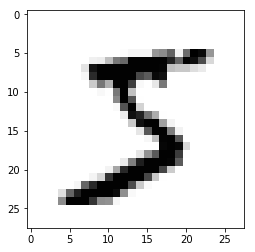

In [3]:
plt.imshow(X_train[0],cmap='Greys')

## Stacked autoencoder

Following the book example, build a stacked autoencoder with 3 hidden layers and 1 output layer using Keras `Model` [functional API](https://keras.io/getting-started/functional-api-guide/).

Use ELU activation (except for output layer - it uses sigmoid since outputs are between 0 and 1), He truncated normal initialization and $L_2$ regularization.

In [4]:
from keras.layers import Dense, Input, Flatten, Reshape
from keras.models import Model
from keras.optimizers import Adam
from keras import regularizers

In [5]:
input_shape = X_train.shape[1:]
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
learning_rate = 0.01
l2_reg = 0.0001

It is common to build autoencoders by blocks.

### Tensors

First, create tensors from which components of deep autoencoder will later be built.

Encoder 1 will take an input (28,28), flatten it to vector of 784 units and condense it to 300 units.

- Tensors for encoder 1:

In [6]:
# for encoder1
input_tensor = Input(shape=input_shape)
flattened = Flatten()(input_tensor)
hidden1 = Dense(n_hidden1, activation='elu', kernel_initializer='he_normal', 
                kernel_regularizer=regularizers.l2(l2_reg))(flattened)
print('input_tensor: ',input_tensor)
print('flattened: ',flattened)
print('hidden1: ',hidden1)

input_tensor:  Tensor("input_1:0", shape=(?, 28, 28), dtype=float32)
flattened:  Tensor("flatten_1/Reshape:0", shape=(?, ?), dtype=float32)
hidden1:  Tensor("dense_1/Elu:0", shape=(?, 300), dtype=float32)


Note that hidden layer includes `elu` activation, `he_normal` kernel initializer and `l2_reg` regularizator.

Initializer `he_normal` draws random initial weights from truncated normal distribution with mean 0 and standard deviation $\sqrt{\frac{2}{n_{weights}}}$.

Regularizator `l2` adds penalty to the loss function as
$$L(w)+\lambda \sum_i w_i^2,$$
where $\lambda =$ `l2_reg`.

Encoder 2 will create codings of 150 units from 300 units received from encoder 1.

- Tensors for encoder 2:

In [7]:
# for encoder2
input_enc2 = Input(shape=(n_hidden1,))
hidden2 = Dense(n_hidden2, activation='elu', kernel_initializer='he_normal', 
                kernel_regularizer=regularizers.l2(l2_reg))(input_enc2)
print('input_enc2: ',input_enc2)
print('hidden2: ',hidden2)

input_enc2:  Tensor("input_2:0", shape=(?, 300), dtype=float32)
hidden2:  Tensor("dense_2/Elu:0", shape=(?, 150), dtype=float32)


Following encoder 2 is decoder 2: it takes codings from encoder 2 and decodes them to 300 units.

- Tensors for decoder 2:

In [8]:
# for decoder2
input_dec2 = Input(shape=(n_hidden2,))
hidden3 = Dense(n_hidden3, activation='elu', kernel_initializer='he_normal', 
                kernel_regularizer=regularizers.l2(l2_reg))(input_dec2)
print('input_dec2: ',input_dec2)
print('hidden3: ',hidden3)

input_dec2:  Tensor("input_3:0", shape=(?, 150), dtype=float32)
hidden3:  Tensor("dense_3/Elu:0", shape=(?, 300), dtype=float32)


Final step of decoding - decoder 1 - takes input of 300 units from decoder 2, further decodes them to 784 units (flattened output) and reshapes flattened output into the original shape (28,28).

- Tensors for decoder 1:

In [9]:
input_dec1 = Input(shape=(n_hidden1,))
flattened_outputs = Dense(np.prod(input_shape), activation='sigmoid', kernel_initializer='he_normal', 
                          kernel_regularizer=regularizers.l2(l2_reg))(input_dec1)
outputs = Reshape(input_shape)(flattened_outputs)
print('input_dec1: ',input_dec1)
print('flattened_outputs: ',flattened_outputs)
print('outputs: ',outputs)

input_dec1:  Tensor("input_4:0", shape=(?, 300), dtype=float32)
flattened_outputs:  Tensor("dense_4/Sigmoid:0", shape=(?, 784), dtype=float32)
outputs:  Tensor("reshape_1/Reshape:0", shape=(?, 28, 28), dtype=float32)


### Models

Using defined tensors construct models for separate components of autoencoder.

- Encoder. Create models of encoder 1 and encoder 2 and combine them in a model of encoder:

In [10]:
from keras.utils import plot_model

In [11]:
# encoder
encoder1 = Model(input_tensor, hidden1, name='encoder_1')
encoder2 = Model(input_enc2, hidden2, name='encoder_2')
encoder = Model(input_tensor, encoder2(encoder1(input_tensor)), name='encoder')
plot_model(encoder1, to_file='encoder1.png',show_shapes=True,show_layer_names=True)
plot_model(encoder2, to_file='encoder2.png',show_shapes=True,show_layer_names=True)
plot_model(encoder, to_file='encoder.png',show_shapes=True,show_layer_names=True)

Architecture of encoder 1:

![Encoder1 plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fencoder1.png)

Architecture of encoder 2:

![Encoder2 plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fencoder2.png)

Architecture of encoder:

![Encoder plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fencoder.png)

- Decoder: create models for decoder 2, decoder 1 and combine them in a model for decoder:

In [12]:
# decoder
decoder2 = Model(input_dec2, hidden3, name='decoder_2')
decoder1 = Model(input_dec1, outputs, name='decoder_1')
decoder = Model(input_dec2, decoder1(decoder2(input_dec2)), name='decoder')
plot_model(decoder2, to_file='decoder2.png',show_shapes=True,show_layer_names=True)
plot_model(decoder1, to_file='decoder1.png',show_shapes=True,show_layer_names=True)
plot_model(decoder, to_file='decoder.png',show_shapes=True,show_layer_names=True)

Architecture of decoder 2:

![Decoder2 plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fdecoder2.png)

Architecture of decoder 1:

![Decoder1 plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fdecoder1.png)

Architecture of decoder:

![Decoder plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fdecoder.png)

### Autoencoder assembled

Finally, combine encoder and decoder in deep autoencoder.

In [13]:
# autoencoder
autoencoder = Model(input_tensor, decoder(encoder(input_tensor)), name='autoencoder')
plot_model(autoencoder, to_file='autoencoder.png',show_shapes=True,show_layer_names=True)

Autoencoder architecture:

![Autoencoder plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fautoencoder.png)

Compile autoencoder, save initial weights and print summary.

In [14]:
autoencoder.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
autoencoder.save_weights('ae_initial_weights.h5') # save initial weights (to re-produce results in the next sections)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 150)               280650    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            281284    
Total params: 561,934
Trainable params: 561,934
Non-trainable params: 0
_________________________________________________________________


Train autoencoder:

In [15]:
n_epochs = 4
batch_size = 150

autoencoder.fit(X_train, X_train,
                epochs=n_epochs,
                batch_size=batch_size,
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 15s 244us/step - loss: 0.2144 - val_loss: 0.1515
Epoch 2/4
60000/60000 [==============================] - 13s 224us/step - loss: 0.1512 - val_loss: 0.1495
Epoch 3/4
60000/60000 [==============================] - 13s 222us/step - loss: 0.1500 - val_loss: 0.1466
Epoch 4/4
60000/60000 [==============================] - 14s 228us/step - loss: 0.1489 - val_loss: 0.1471


Reconstruct some images from test set and plot original images along with reconstruction:

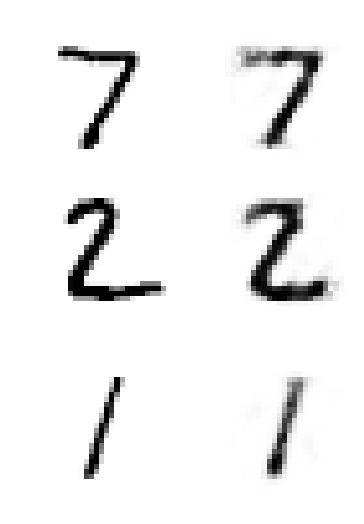

In [16]:
n_test_digits = 3

imgs = X_test[:n_test_digits]
reconstructed_imgs = autoencoder.predict(imgs)


def plot_imgs(*args, n_imgs=None):
    n_cols = len(args)
    if n_imgs is None:
        n_imgs = args[0].shape[0]
    fig = plt.figure(figsize=(3 * n_cols, 3 * n_imgs))
    for row in range(n_imgs):
        for col in range(n_cols):
            plt.subplot(n_imgs, n_cols, row * n_cols + col + 1)
            plt.imshow(args[col][row], cmap='Greys', interpolation='nearest')
            plt.axis('off')


plot_imgs(imgs, reconstructed_imgs)

## Training one Autoencoder at a time

Use the same network architecture, but train only one encoder/decoder at a time.

In [21]:
autoencoder.load_weights('ae_initial_weights.h5') # load initial weights

Check that autoencoder predictions are non-sense after reloading initial weights:

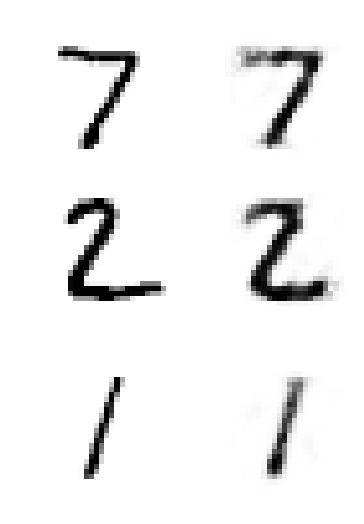

In [17]:
n_test_digits = 3
imgs = X_test[:n_test_digits]
reconstructed_imgs = autoencoder.predict(imgs)
plot_imgs(imgs, reconstructed_imgs)

Define and compile first autoencoder using previously defined tensors:

In [18]:
autoencoder1 = Model(input_tensor, decoder1(encoder1(input_tensor)), name='autoencoder_1')
autoencoder1.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
plot_model(autoencoder1, to_file='autoencoder1.png',show_shapes=True,show_layer_names=True)

Autoencoder 1 architecture:

![Autoencoder1 plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fautoencoder1.png)

Train `autoencoder1`:

In [19]:
n_epochs = 4
batch_size = 150

autoencoder1.fit(X_train, X_train,
                 epochs=n_epochs,
                 batch_size=batch_size,
                 validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 13s 212us/step - loss: 0.1635 - val_loss: 0.1540
Epoch 2/4
60000/60000 [==============================] - 12s 200us/step - loss: 0.1549 - val_loss: 0.1528
Epoch 3/4
60000/60000 [==============================] - 12s 203us/step - loss: 0.1540 - val_loss: 0.1525
Epoch 4/4
60000/60000 [==============================] - 12s 206us/step - loss: 0.1534 - val_loss: 0.1519


Autoencoder 1 by itself may not be needed. But we need to copy the first hidden layer (model `encoder_1`) weights to the final autoencoder and we need outputs of that layer to train encoder 2:

![Stacked Autoencoder1 plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FStackedAESequential.jpg)

Recall definition of the network that was just trained: `decoder1(encoder1(input_tensor))`. This means that `encoder1` and `decoder1` were just trained as models too.

Using them compute intermediate codes (i.e. inputs for `encoder2` and outputs of `decoder2`) for both train and test sets:

In [20]:
X_train_intermediate = encoder1.predict(X_train)
X_test_intermediate = encoder1.predict(X_test)
X_train_intermediate.shape,X_test_intermediate.shape

((60000, 300), (10000, 300))

Define and compile second autoencoder using previously defined tensors. Use mean-squared error loss since intermediate codes are unbounded.

In [21]:
autoencoder2 = Model(input_enc2, decoder2(encoder2(input_enc2)), name='autoencoder_2')
autoencoder2.compile(optimizer=Adam(learning_rate), loss='mse')
plot_model(autoencoder2, to_file='autoencoder2.png',show_shapes=True,show_layer_names=True)

Architecture of autoencoder 2:

![Autoencoder2 plot](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fautoencoder2.png)

Train `autoencoder2` just like `autoencoder1` but using intermediate codings stored in `X_train_intermediate`:

In [22]:
n_epochs = 4
batch_size = 150

autoencoder2.fit(X_train_intermediate, X_train_intermediate,
                 epochs=n_epochs,
                 batch_size=batch_size,
                 validation_data=(X_test_intermediate, X_test_intermediate))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 5s 77us/step - loss: 0.2525 - val_loss: 0.0534
Epoch 2/4
60000/60000 [==============================] - 4s 59us/step - loss: 0.0548 - val_loss: 0.0523
Epoch 3/4
60000/60000 [==============================] - 4s 67us/step - loss: 0.0497 - val_loss: 0.0441
Epoch 4/4
60000/60000 [==============================] - 3s 57us/step - loss: 0.0421 - val_loss: 0.0411


Visualize some reconstructions.

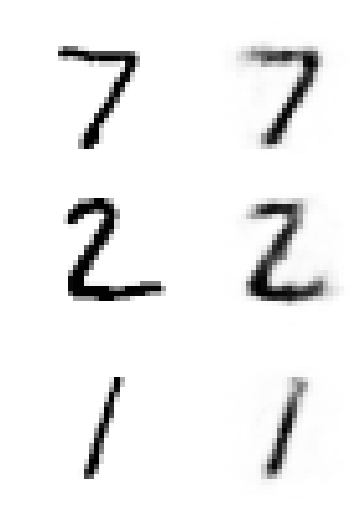

In [23]:
n_test_digits = 3

imgs = X_test[:n_test_digits]
reconstructed_imgs = autoencoder.predict(imgs)

plot_imgs(imgs, reconstructed_imgs)

Visualize some extracted features by plotting reshaped (28x28) weights from first encoding layer.

In [24]:
w = encoder1.get_weights()[0]
w.shape

(784, 300)

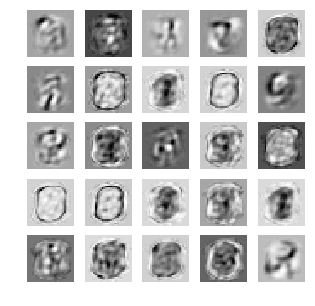

In [25]:
R, C = 5, 5  # rows, columns
plt.figure(figsize=(R, C))
for i in range(R*C):
    plt.subplot(R, C, i + 1)
    plt.imshow(w[:,i].reshape((28, 28)), cmap='Greys', interpolation='nearest')
    plt.axis('off')

**Is it possible to interpret these images?**

## Unsupervised pretraining for supervised problem

Now use pre-trained autoencoder to classify MNIST pictures. Consider 150-dimensional codings generated by encoder as inputs instead of 28x28-images.

In [26]:
X_train_codings = encoder.predict(X_train)
X_test_codings = encoder.predict(X_test)
print(X_train_codings.shape, X_test_codings.shape)

(60000, 150) (10000, 150)


Build simple 1-layer softmax classifier with $L_2$-regularization with codings as inputs.

In [27]:
input_classifier = Input(shape=(n_hidden2,))
softmax_predictions = Dense(10, activation='softmax', kernel_initializer='he_normal',
                            kernel_regularizer=regularizers.l2(l2_reg))(input_classifier)

classifier = Model(inputs=input_classifier, outputs=softmax_predictions, name='classifier')

classifier.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1510      
Total params: 1,510
Trainable params: 1,510
Non-trainable params: 0
_________________________________________________________________


In [28]:
plot_model(classifier, to_file='classifier.png',show_shapes=True,show_layer_names=True)

Architecture of classifier:

![Classifier](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fclassifier.png)

Finally, train classifier network.

In [29]:
n_epochs = 4
batch_size = 150

classifier.fit(X_train_codings, y_train,
               epochs=n_epochs,
               batch_size=batch_size,
               validation_data=(X_train_codings, y_train))

Train on 60000 samples, validate on 60000 samples
Epoch 1/4
60000/60000 [==============================] - 2s 29us/step - loss: 0.4867 - acc: 0.8541 - val_loss: 0.3629 - val_acc: 0.8948
Epoch 2/4
60000/60000 [==============================] - 1s 22us/step - loss: 0.3625 - acc: 0.8950 - val_loss: 0.3591 - val_acc: 0.8941
Epoch 3/4
60000/60000 [==============================] - 2s 33us/step - loss: 0.3520 - acc: 0.8983 - val_loss: 0.3372 - val_acc: 0.9030
Epoch 4/4
60000/60000 [==============================] - 2s 27us/step - loss: 0.3541 - acc: 0.8969 - val_loss: 0.3440 - val_acc: 0.9016


Unsupervised pretraining approach is especially useful when labeled train set is small, while test set is large (as usually happens in real life since collecting data is much simpler and/or cheaper than labeling it). 

Just train autoencoder on the concatenation of `X_train` and `X_test` and train classifier using `X_train_codings` and predict `y_test` using `X_test_codings`.

Check predictions by the classifier:

In [30]:
import pandas as pd
y_test_predictions = classifier.predict(X_test_codings)
print('Class probabilities: \n',pd.DataFrame(y_test_predictions[:5]).round(2))
print('Actual: ',y_test[:5])

Class probabilities: 
       0     1     2    3     4    5     6     7    8     9
0  0.00  0.00  0.00  0.0  0.00  0.0  0.00  1.00  0.0  0.00
1  0.01  0.00  0.93  0.0  0.00  0.0  0.06  0.00  0.0  0.00
2  0.00  0.99  0.00  0.0  0.00  0.0  0.00  0.00  0.0  0.00
3  1.00  0.00  0.00  0.0  0.00  0.0  0.00  0.00  0.0  0.00
4  0.00  0.00  0.00  0.0  0.93  0.0  0.00  0.01  0.0  0.06
Actual:  [7 2 1 0 4]


## Stacked Denoising Autoencoder

Autoencoders also can be a useful method for cleaning noisy data.

### Gaussian noise

Add some gaussian noise to inputs and compile denoiser:

In [31]:
autoencoder.load_weights('ae_initial_weights.h5')  # load initial weights

import keras.backend as K
from keras.layers import Lambda


def add_noise(x, noise_level = 0.5):
    x = x + K.random_normal(shape=K.shape(x), stddev=noise_level)
    x = K.clip(x, 0., 1.)  # assure 0 <= x <= 1
    return x


noised_img = Lambda(add_noise)(input_tensor)
noiser = Model(input_tensor, noised_img, name='noiser')
denoiser = Model(input_tensor, autoencoder(noiser(input_tensor)), name='denoiser')

denoiser.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')

Train denoising autoencoder:

In [32]:
n_epochs = 4
batch_size = 150

denoiser.fit(X_train, X_train,
             epochs=n_epochs, batch_size=batch_size,
             validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 16s 261us/step - loss: 0.2764 - val_loss: 0.1894
Epoch 2/4
60000/60000 [==============================] - 15s 249us/step - loss: 0.1853 - val_loss: 0.1836
Epoch 3/4
60000/60000 [==============================] - 16s 275us/step - loss: 0.1826 - val_loss: 0.1780
Epoch 4/4
60000/60000 [==============================] - 15s 253us/step - loss: 0.1810 - val_loss: 0.1828


Check results. Original images are on the left, noised are in cener, denoised are on the right.

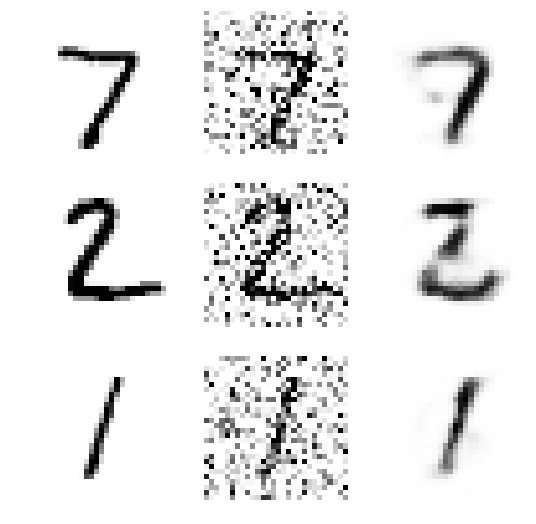

In [33]:
n = 3

imgs = X_test[:n]
noised_imgs = noiser.predict(imgs)
denoised_imgs = autoencoder.predict(noised_imgs)

plot_imgs(imgs, noised_imgs, denoised_imgs)

### Dropout noise
Instead of white noise one might want to use dropout layer on input image. 

In [34]:
autoencoder.load_weights('ae_initial_weights.h5')  # reload initial weights

from keras.layers import Dropout

dropout_rate = 0.8  # drop ~80% (!!!) of pixels
dropout_img = Dropout(rate=dropout_rate)(input_tensor, training=True)  # training=True activates dropout during prediction

noiser_dropout = Model(input_tensor, dropout_img, name='noiser_dropuot')
denoiser_dropout = Model(input_tensor, autoencoder(noiser_dropout(input_tensor)), name='denoiser_dropout')    

denoiser_dropout.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')

Train dropout denoiser:

In [35]:
n_epochs = 4
batch_size = 150

denoiser_dropout.fit(X_train, X_train,
                     epochs=n_epochs, batch_size=batch_size,
                     validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/4
60000/60000 [==============================] - 15s 256us/step - loss: 0.2509 - val_loss: 0.2018
Epoch 2/4
60000/60000 [==============================] - 15s 247us/step - loss: 0.2031 - val_loss: 0.1995
Epoch 3/4
60000/60000 [==============================] - 15s 244us/step - loss: 0.2008 - val_loss: 0.1999
Epoch 4/4
60000/60000 [==============================] - 15s 253us/step - loss: 0.1999 - val_loss: 0.1991


And check results:

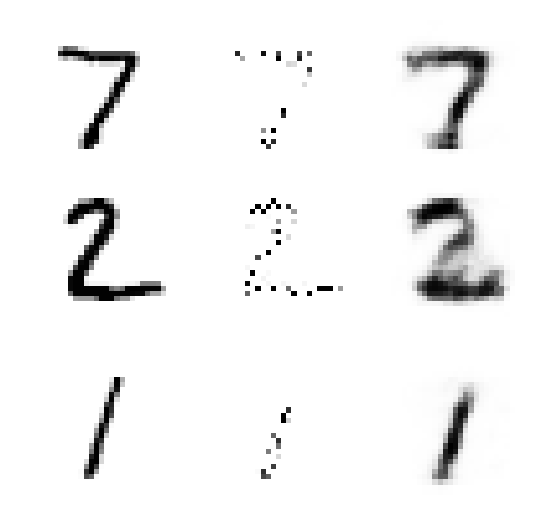

In [36]:
n = 3

imgs = X_test[:n]
noised_imgs = noiser_dropout.predict(imgs)
denoised_imgs = autoencoder.predict(noised_imgs)

plot_imgs(imgs, noised_imgs, denoised_imgs)

## Sparse Autoencoder

Instead of penalizing autoencoder *weights* one may decide to penalize *codes*, so fewer units would "fire" at a given time. In Keras, this can be done by adding an `activity_regularizer` to the last encoder layer.

Define two 1-hidden-layer autoencoders. First one is vanilla autoencoder, while the second is sparse with $L_1$-regularizer for codes.

In [37]:
def create_autoencoder(input_shape, n_hidden1, sparse=True, sparsity_weight=1e-5):
    # tensors:
    input_tensor = Input(shape=input_shape)
    flattened = Flatten()(input_tensor)
    regularizer = regularizers.l1(sparsity_weight) if sparse else None
    hidden1 = Dense(n_hidden1, activation='relu', kernel_initializer='he_normal', 
                    activity_regularizer=regularizer)(flattened)
    input_decoder = Input(shape=(n_hidden1,))
    flattened_outputs = Dense(np.prod(input_shape), activation='sigmoid', 
                              kernel_initializer='he_normal')(input_decoder)
    outputs = Reshape(input_shape)(flattened_outputs)
    # models:
    encoder = Model(input_tensor, hidden1, name='encoder')
    decoder = Model(input_decoder, outputs, name='decoder')
    autoencoder = Model(input_tensor, decoder(encoder(input_tensor)), name='autoencoder')
    return encoder, decoder, autoencoder


input_shape = X_train.shape[1:]
n_hidden1 = 300
sparsity_weight = 1e-5
encoder, decoder, autoencoder = create_autoencoder(input_shape, n_hidden1, sparse=False)
s_encoder, s_decoder, s_autoencoder = create_autoencoder(input_shape, n_hidden1, 
                                                         sparse=True, sparsity_weight=sparsity_weight)

Compile both autoencoders:

In [38]:
learning_rate = 0.01
autoencoder.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
s_autoencoder.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy')
s_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 28, 28)            0         
_________________________________________________________________
encoder (Model)              (None, 300)               235500    
_________________________________________________________________
decoder (Model)              (None, 28, 28)            235984    
Total params: 471,484
Trainable params: 471,484
Non-trainable params: 0
_________________________________________________________________


Train both autoencoders:

In [39]:
n_epochs = 2
batch_size = 150

autoencoder.fit(X_train, X_train,
                epochs=n_epochs,
                batch_size=batch_size,
                validation_data=(X_test, X_test))

s_autoencoder.fit(X_train, X_train,
                  epochs=n_epochs,
                  batch_size=batch_size,
                  validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 221us/step - loss: 0.0980 - val_loss: 0.0722
Epoch 2/2
60000/60000 [==============================] - 12s 205us/step - loss: 0.0705 - val_loss: 0.0682
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 13s 211us/step - loss: 0.1887 - val_loss: 0.1502
Epoch 2/2
60000/60000 [==============================] - 12s 194us/step - loss: 0.1463 - val_loss: 0.1396


Check results:

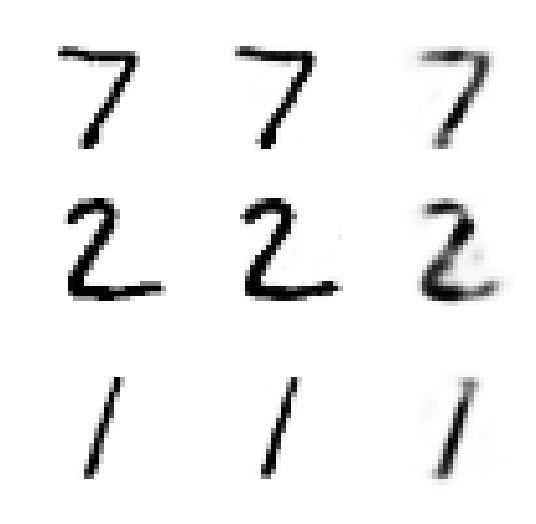

In [40]:
n_test_digits = 3

imgs = X_test
codings = encoder.predict(imgs)
reconstructed_imgs = decoder.predict(codings)
sparse_codings = s_encoder.predict(imgs)
s_reconstructed_imgs = s_decoder.predict(sparse_codings)

plot_imgs(imgs, reconstructed_imgs, s_reconstructed_imgs, n_imgs=n_test_digits)

Calculate mean absolute value of codings:

In [42]:
print('Vanilla autoencoder mean-absolute-codings: ', np.mean(np.abs(codings)))
print('Sparse  autoencoder mean-absolute-codings: ', np.mean(np.abs(sparse_codings)))

Vanilla autoencoder mean-absolute-codings:  1.11004
Sparse  autoencoder mean-absolute-codings:  0.0509125


New model yields encoded representations that are much sparser.

In [43]:
print('Vanilla autoencoder zero fraction: ', np.mean(codings == 0))
print('Sparse  autoencoder zero fraction: ', np.mean(sparse_codings == 0))

Vanilla autoencoder zero fraction:  0.544154333333
Sparse  autoencoder zero fraction:  0.937753666667
